# Simple Bayes Generative Model

Fit data to a gaussian model then sample from it.

* $P(Y|X)$ is the probability of being class Y given image X
* $P(X|Y)$ is the generative model which generate image X given Y.
  $$P(X|Y) = \frac{P(Y|X)\ P(X)}{P(Y)}$$

Given the training data, we can fit the data to a gaussian model to build $P(X|Y)$ and then sample from this gaussian model to generate some images. The following block is doing this task for MNIST dataset

Reading in and transforming data...


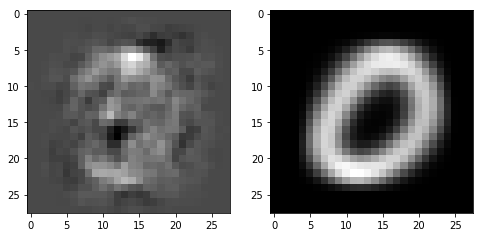

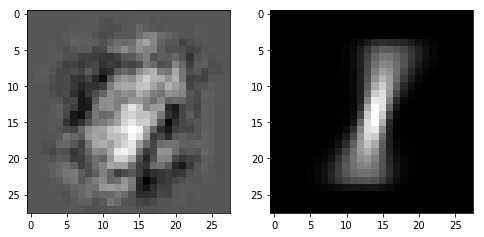

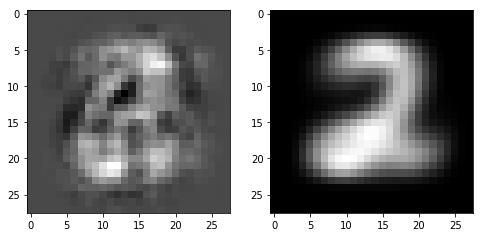

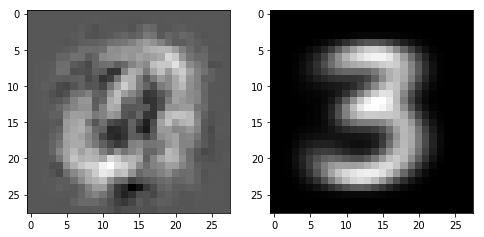

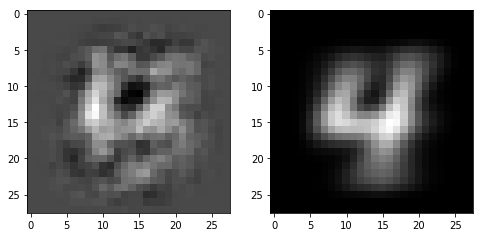

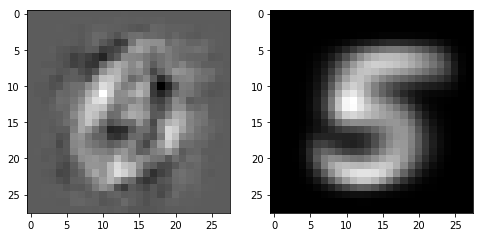

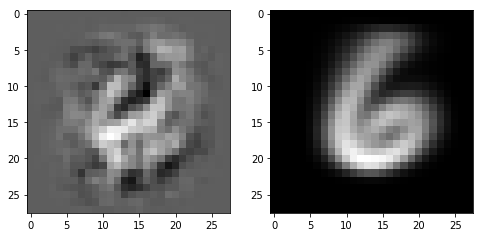

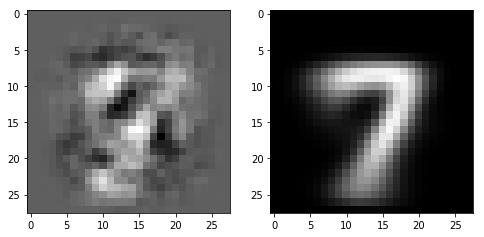

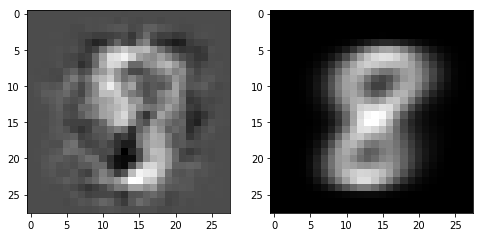

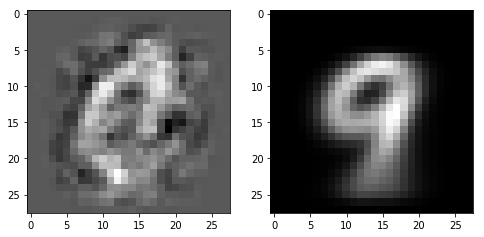

In [14]:
import util
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt


class bayes_generator:
    def fit(self,x,y):
        self.n_cats = len(set(y))
        self.distributions = []
        for cat in range(self.n_cats):
            xK = x[y == cat]
            mean = np.mean(xK,axis = 0)
            cov = np.cov(x.T) # np.cov assumes each row is one variable (here pixel)
            gaussian_dis = {"m":mean, "c": cov}
            self.distributions.append(gaussian_dis)
    
    def sample_give_y(self,cat):
        dist = self.distributions[cat]
        return mvn.rvs(mean = dist["m"],cov=dist["c"])
    

X, Y = util.get_mnist()
gen = bayes_generator()
gen.fit(X,Y)
n_samples = 10
for k in range(n_samples):
    sample_generated = gen.sample_give_y(k).reshape(28,28)
    mean = gen.distributions[k]["m"].reshape(28, 28)
    plt.figure(figsize=(8,16))
    plt.subplot(121)
    plt.imshow(sample_generated,cmap='gray')
    plt.subplot(122)
    plt.imshow(mean,cmap='gray')
    plt.show()

# Using Multimodal Bayes

Without Multimodal, the model cannot for example model the translation and rotation inside image.

How to model it:
* Using [GMM](https://youtu.be/Rkl30Fr2S38) (Gaussian Mixture Model) from scikit learn
* GMM fit miltiple Gaussians with different weigths to the data
* GMM is latent variable model
* Laten variable $z$ represents which cluster $x$ blongs to
* i.e. 2 Clusters: $p(x) = p(z=1)p(x|z=1)+p(z=2)p(x|z=2)$
* $p(z)$ priority that any x belongs ot a cluster $z$
* $p(z)$ is categorical/discrete distribution (vector of numbers that sums to 1)
* $p(x|z)$ is single gaussian


how to assign the cluster:
* Use Bayes Rule!
* $P(z|x) = P(x|z)P(z)/P(x)$

* GMM is trained via expectation-maximization (EM)
* EM is iterative
* You need to choose number of clusters -> solution: VI-GMM

Graphical Model

GMM:
* y --------> z ---------> x
* sample $y\sim p(y)$ (class frequency)
* sample $z\sim p(z|y)$ (Wrting Style)
* sample $x\sim p(x|z,y)$ (image)

Reading in and transforming data...


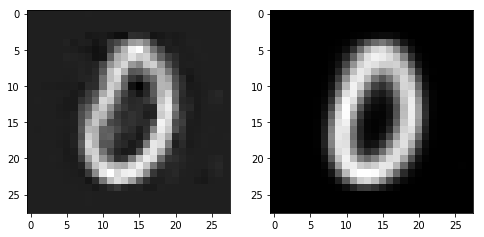

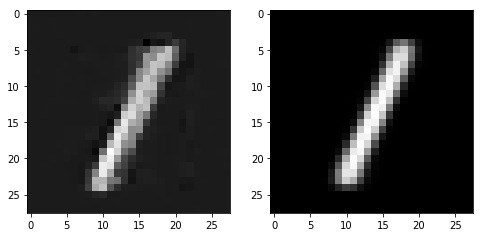

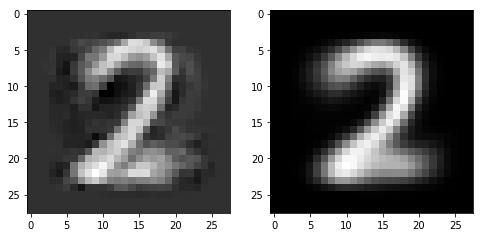

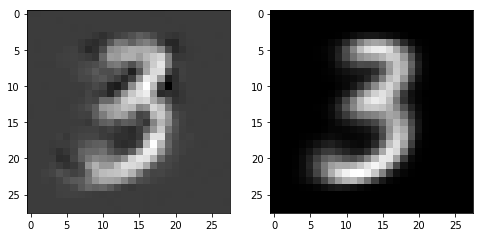

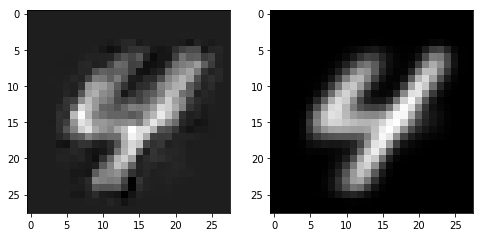

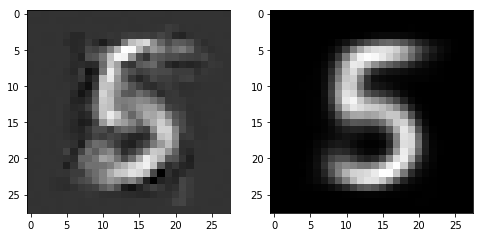

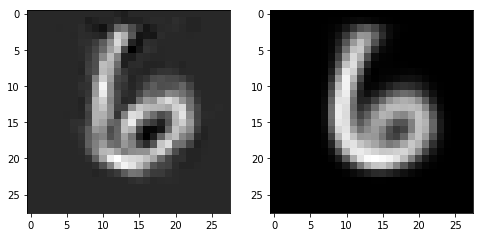

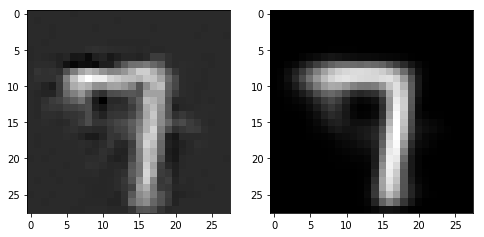

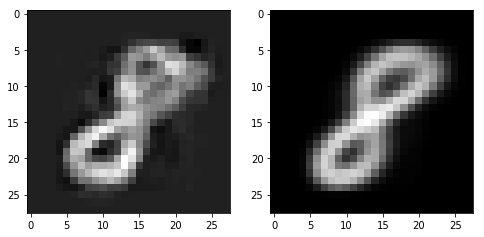

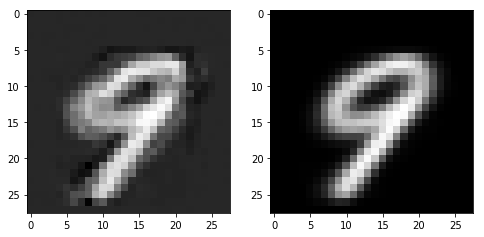

In [21]:
# this block is a lot slower than the previous block.
# but results are much better than the previous.
from sklearn.mixture import BayesianGaussianMixture as bgm

class gmm_gen:
    def __init__(self):
        self.distributions = []
        
    def fit(self,x,y,num):
        self.n_cats = len(set(y))
        self.distributions = []
        for cat in range(self.n_cats):
            xK = x[y == cat]
            gmm = bgm(num)
            gmm.fit(xK)
            self.distributions.append(gmm)
    
    def sample_give_y(self,cat):
        dist = self.distributions[cat]
        sample, cluster = dist.sample()
        meanOfCluster = dist.means_[cluster]
        return sample.reshape(28,28), meanOfCluster.reshape(28,28)

num_styles = 10
X, Y = util.get_mnist()
gen = gmm_gen()
gen.fit(X,Y,num_styles)
n_samples = 10
for k in range(n_samples):
    sample_generated, cluster_mean = gen.sample_give_y(k)
    plt.figure(figsize=(8,16))
    plt.subplot(121)
    plt.imshow(sample_generated,cmap='gray')
    plt.subplot(122)
    plt.imshow(cluster_mean,cmap='gray')
    plt.show()